# ENEL 645 Final Project : ASL Recognition

This project explores two deep learning model that can classify American Sign Language (ASL) through images. The dataset used in this project contains 87000 images of ASL with 29 labels.

The four models we explored are: ResNet50, VGG16, GoogleNet and our custom model both with data visulization, accuracy measurement for validation and testing. The two models were training with similar conditions and a comparison is drawn between the two at the end of this notebook.

--- 
Dataset is required from the following source:

* ASL Alphabet: image dataset for alphabets in the American Sign Language. Retrieved from https://www.kaggle.com/datasets/grassknoted/asl-alphabet

For setting up the deep learning models we used the following resource:
* https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html

This notebook will walk you through steps for training, validating and testing the four above-mentioned models. Please refer to our report and presentation for additional information regarding this project.  

# 1- Installing Libraries and Importing Packages

libraries used in this project are: Pytorch, MatPlotLib, Numpy, Glob. 
Pytorch is used as the main machine learning framework for this project for training, validation and testing as well as image manipulation and augmentation. MatPlotLib is used to depict the images to the screen as well as ploting the progress of loss and accuracy through the training. Glob is used for pathnames and Numpy is used for numerical manipulation.


Since the data we are working with is image files, it would be more efficient to leave the training tasks to an engine type of GPU. So we first check if any GPU engine is available for this notebook from google Colab. 

## 1.1- Install required libraries

In [ ]:
# Install the Necessary Packages (for Local Notebook). Uncomment the following block out:

# %pip install torch
# %pip install torchvision
# %pip install matplotlib
# %pip install numpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## 1.2- Import required packages

In [ ]:
import torch # pytorch main library 
import torchvision # computer vision utilities
from torchvision import models
import torchvision.datasets as datasets
import torchvision.transforms as transforms # transforms used in the pre-processing of the data

from torch.utils.data import Dataset, DataLoader  # for loading hte MNIST Data
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np

import glob

# Check if GPU is available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

cuda:0


# 2- Defining Utility Functions

This section introduces the global functions that will be used throughout the notebook including: 
* `get_dataset_stats`: this function will calculate the mean and standard deviation of dataset. (later used for normalization)

* `imshow`: this function will unnormalize the image and show it on screen

In [ ]:
# Function to get the statistics of a dataset
def get_dataset_stats(data_loader):
    """
    Input: Data loader that contains batches of image tensors
    Output: Sample mean and std
    """ 
    mean = 0
    std = 0
    nb_samples = 0
    counter = 1
    for data in data_loader:
        data = data[0] # Get the images to compute the statistics
        batch_samples = data.size(0)
        data = data.view(batch_samples, data.size(1), -1)
        mean += data.mean(2).sum(0)
        std += data.std(2).sum(0)
        nb_samples += batch_samples
        counter += 1
    
    mean /= nb_samples
    std /= nb_samples
    return mean,std

# functions to show an image
def imshow(img, stats):
    """
    Input: an image tensor
    Output: images
    """
    img = img *stats[1] + stats[0]     # unnormalize the tensor
    npimg = img.numpy() # convert the tensor back to numpy
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# 3- Importing Datasets from Kaggle
- Step 1: *Upload personal Kaggle's API (kaggle.json) into the root folder*
- Step 2: Code will download and import datasets from Kaggle
- Step 3: Code will unzip the datasets

**NOTE**: to be able to run the following code, you need to have an account with Kaggle, then navigate to `Profile` -> `Account` -> `API` then press on `create new API` to get a json file. upload the json file on the files of this project

In [ ]:
# Read datasets from Kaggle
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download grassknoted/asl-alphabet # the data route on Kaggle
! unzip asl-alphabet.zip #unzip to different class folder

Streaming output truncated to the last 5000 lines.
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing19.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing190.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1900.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1901.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1902.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1903.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1904.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1905.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1906.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1907.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1908.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1909.jpg  
  inflating: asl_alphabet_tr

# 4- Exploring the Dataset

To get an idea of what the dataset looks like, we will look at some features of the dataset, such as image size, statistics, labels, or sample data points.

The Kaggle's dataset are provided via two folders: `test` and `train`. But we won't use the data provided in `test` folder as it has only 29 samples. We will in turn use the data from `train` folder and further split it to train set : validation set : test set with the ratio of = 0.7 : 0.2: 0.1  

Some observations & setup from the follwing code cells: 

- The data is balanced across all classes
- Sample size: 87,000 images
- Image size: 200 x 200 pixels
- 29 classes in total: 26 are for A-Z, 3 are for SPACE, DELETE, and NOTHING
   

## 4.1- Load the data as Numpy arrays

In [ ]:
# read the dev set and test set
data_dir = '/content/asl_alphabet_train/asl_alphabet_train'

# Getting the image arrays and their corresponding labels
data_images = np.asarray(glob.glob(data_dir + "/*/*.jpg"))
data_labels = np.asarray( [f.split("/")[-2] for f in data_images])


## 4.2- Check the sample distribution among the classes

classes are ['A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'J' 'K' 'L' 'M' 'N' 'O' 'P' 'Q' 'R'
 'S' 'T' 'U' 'V' 'W' 'X' 'Y' 'Z' 'del' 'nothing' 'space']
Label  A : 3000
Label  B : 3000
Label  C : 3000
Label  D : 3000
Label  E : 3000
Label  F : 3000
Label  G : 3000
Label  H : 3000
Label  I : 3000
Label  J : 3000
Label  K : 3000
Label  L : 3000
Label  M : 3000
Label  N : 3000
Label  O : 3000
Label  P : 3000
Label  Q : 3000
Label  R : 3000
Label  S : 3000
Label  T : 3000
Label  U : 3000
Label  V : 3000
Label  W : 3000
Label  X : 3000
Label  Y : 3000
Label  Z : 3000
Label  del : 3000
Label  nothing : 3000
Label  space : 3000


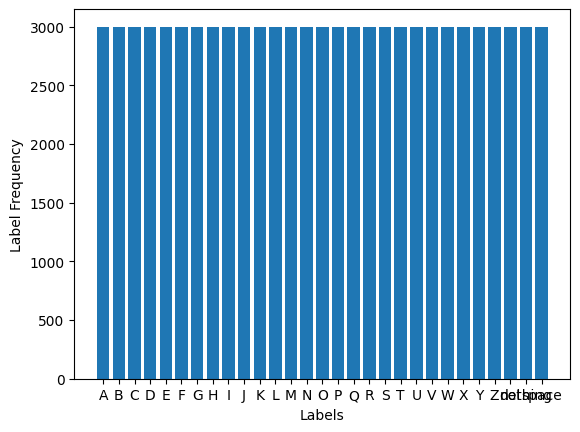

In [ ]:
classes = np.unique(data_labels)
print(f"classes are {classes}")

labels_count = []

for i in classes:
    count = (data_labels == i).sum()
    labels_count.append(count)
    print("Label ", i, ":", count)

plt.figure()
plt.bar(x=classes, height=labels_count)
plt.xlabel("Labels")
plt.ylabel("Label Frequency")
plt.show()

# 5- Defining Experimental Setup

The experimental setup used for this project is formed by split the dataset into train, validation and test set. Before splitiing the data into train, validation and test set, we first calculate the statistics of training set.


In the next step, we define the transformations that are needed for preparing the data for passing to models. Transformations used include resizing the images to 224 (for ResNet), and normalizing the image according to stats aquired from previous step. 


In the last step, we define dataloaders for training, validating and testing data sets using the batch size of 100 samples per batch.

At the end of this step, we visualize the data and map the classes.

## 5.1- Calculate statistics of data

In [ ]:
# Experimental Setup
transform = transforms.Compose([transforms.ToTensor()]) 
dataset = datasets.ImageFolder(data_dir, transform=transform)

train_split = 0.7 # train split
val_split = 0.9 # val split

train_set_size = int(len(dataset) * train_split)
val_set_size = int(len(dataset) *  val_split) - train_set_size
test_set_size = len(dataset) - (train_set_size + val_set_size)
print("Experimental Setup: Train:", train_set_size, "|Validation:", val_set_size,"| Test:",test_set_size)

# Split the development set into train and validation
train_set, val_set, test_set = torch.utils.data.random_split(dataset, [train_set_size, val_set_size, test_set_size], generator=torch.Generator().manual_seed(42))

Experimental Setup: Train: 60899 |Validation: 17401 | Test: 8700


In [ ]:
# Initialize Loaders
train_loader = torch.utils.data.DataLoader(train_set, batch_size=100, shuffle=True,)

# getting the train stats
train_stats = get_dataset_stats(train_loader)

print("Train Stats: matrix mean and std are", train_stats)


Train Stats: matrix mean and std are (tensor([0.5191, 0.4993, 0.5141]), tensor([0.2044, 0.2333, 0.2419]))


## 5.2- Define transformations and dataloaders

In [ ]:
# new transformations based on the stats and resize needed for resnet50
transformations = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((train_stats[0]), (train_stats[1]))
])

# Determine the portions of train, validation and test set
train_set_size = int(len(dataset) * train_split)
val_set_size = int(len(dataset) *  val_split) - train_set_size
test_set_size = len(dataset) - (train_set_size + val_set_size)
print("Experimental Setup: Train:", train_set_size, "|Validation:", val_set_size,"| Test:",test_set_size)

# Apply the transformations and update the data sets
dataset = datasets.ImageFolder(data_dir, transform = transformations)
train_set, val_set, test_set = torch.utils.data.random_split(dataset, [train_set_size, val_set_size, test_set_size], generator=torch.Generator().manual_seed(42))

# Creating a subset from the rest of the test data. https://stackoverflow.com/questions/73483902/pytorch-subset-on-dataloader-decrease-number-of-data
test_subset = torch.utils.data.Subset(test_set, range(2000)) 

# creating the data loader for each dataset
batch_size = 100
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_subset, batch_size=batch_size, shuffle=False)

Experimental Setup: Train: 60899 |Validation: 17401 | Test: 8700


## 5.3- Visualize training images

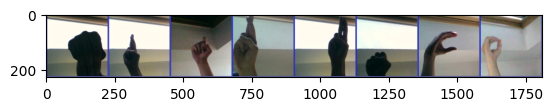

M       | R       | X       | R       | U       | S       | C       | O    


In [ ]:
# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images[:8]), (train_stats[0].mean(), train_stats[1].mean()) )
 
# print labels
print('   | '.join(f'{classes[labels[j]]:5s}' for j in range(8)))


## 5.4- Map the classes to numbers

In [ ]:
# One class for each letter and three additional classes
classes = ('0: A', '1: B', '2: C', '3: D', '4: E', '5: F', '6: G', 
           '7: H', '8: I', '9: J', '10: K','11: L','12: M', '13: N', 
           '14: O', '15: P','16: Q', '17: R', '18: S', '19: T', '20: U',
           '21: V', '22: W', '24: X', '25: Y', '26: Z','27: del', '28: nothing', '29: space') 

# 6- Setting up first Convolutional Neural Network model - ResNet50

As mentioned in the introduction, we will be investigating the ASL alphabet dataset using 3 pre-trained models and 1 custom untrained CNN model. The first model we explore is a pre-trained ResNet50 which consists of convolutional layers, max pooling layers and average pooling layers as well as stacking some residual blocks. The details of the model are included in the report.

## 6.1- loading Resnet50 from Pytorch as deep learning model

The following will also print a summary of the model's layers.

In [ ]:
#importing resnet from torch models 
resnet = models.resnet50(weights='ResNet50_Weights.DEFAULT') # pre-trained ResNet model

# freezing the parameters (--> no training on resnet parameters)
for param in resnet.parameters():
    param.requires_grad = False

# set output classes to the classes we have in dataset
in_features = resnet.fc.in_features
fc = nn.Linear(in_features=in_features, out_features=len(classes))
resnet.fc = fc

# print the model details
resnet

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 91.1MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## 6.2- Setting up the trainable parameters, loss criterion and optimization model for training

This block of code will check with parameters need to be updated during the training. Since it was previous all set to False, we will only be updating the parameters of the final layer. Cross entropy is used as the criterion loss functions. For optimization, Adam's method is used for defining steps in gradient descent. 

In [ ]:
# selecting paramerters to be updated during training
params_to_update = []
for name, param in resnet.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)

# setting up optimization and loss fucntion
resnet_criterion = nn.CrossEntropyLoss()
resnet_optimizer = torch.optim.Adam(params_to_update, lr=0.001)

## 6.3- Defining the forward and backward step in training and validating step

Define a function that receives the model, training and validation loader, loss criterion and optimizer.  It then proceeds through batches of data to calculate the loss, the propagates backward to update weights according to optimizer. It saves the best model in each epoch and prints accuracy and loss value of both training and validation set. This function will be used for the training for the 4 models.

In [ ]:
from time import time

# setting up the training and validations steps

def train(model, criterion, optimizer, train_dataloader, val_dataloader, num_epoch):
    """
    Input: Deep Learning Model, criterion, optimizer, training data, validation data, number of epoches
    Output: Best model, list with the accuracy and losses for both training and validation
    """ 
    best_loss = 1e+20
    best_state = 0 
    steps = 0
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    model.to(device)
    for epoch in range(num_epoch):
        running_loss = 0
        correct_train = 0
        total_train = 0
        start_time = time()

        # Training  
        model.train()
        for i, (images, labels) in enumerate(train_dataloader):
            steps += 1 # Increment steps/count
            # Transfer images and labels to GPU
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            output = model(images)
            loss = criterion(output, labels)

            # Increment correct train if predicted is same as the label
            correct_train += (torch.max(output, dim=1)[1] == labels).sum() 
            total_train += labels.size(0)

            optimizer.zero_grad() # Initialize a gradient of zero
            loss.backward() # Propogate error backwards
            optimizer.step() # Optimize parameters

            running_loss += loss.item()

        # Validation
        model.eval()    
        with torch.no_grad():
            correct_val, total_val = 0, 0
            val_loss = 0
            for images, labels in val_dataloader:
                # Transfer images and labels to GPU
                images, labels = images.to(device), labels.to(device)
        
                # Forward pass
                output = model(images)
                loss = criterion(output, labels)

                val_loss += loss.item()

                # Increment correct validation if predicted is same as the label
                correct_val += (torch.max(output, dim=1)[1] == labels).sum()
                total_val += labels.size(0)

            # Save best model
            if val_loss < best_loss:
                best_loss = val_loss
                print("Saving model") 
                best_state = model.state_dict()

        # Logging
        train_loss = running_loss / steps
        train_accuracy = 100 * correct_train / total_train

        validation_loss = val_loss / len(val_dataloader)
        val_accuracy = 100* correct_val / total_val

        # Printing
        print(f'\nEpoch {epoch+1}, Batch {i+1}, Step {steps}:')
        print(f'Train acc {train_accuracy:.3f}. Train loss {train_loss:.3f} | Val loss {val_loss / len(val_dataloader):.3f}. Val acc {val_accuracy:.3f}.', end=' ')

        # Appending accuracy and losses to the list
        train_accuracies.append(train_accuracy)
        train_losses.append(train_loss)
        val_accuracies.append(val_accuracy)
        val_losses.append(validation_loss)

        print(f'Epoch took {time() - start_time} seconds') 
        
    return best_state, train_losses, val_losses, train_accuracies, val_accuracies


## 6.4- Train and evaluate the model and print the results

In [ ]:
num_epoch = 3

# Put the model to train and validate. Return the best model, and 4 lists containing losses and accuracies
best_state_resnet, train_losses_resnet, val_losses_resnet, train_accuracies_resnet, val_accuracies_resnet = train(
    model=resnet,
    criterion=resnet_criterion,
    optimizer=resnet_optimizer,
    train_dataloader=train_loader,
    val_dataloader=val_loader,
    num_epoch=num_epoch
)

Saving model

Epoch 1, Batch 609, Step 609:
Train acc 80.093. Train loss 1.226 | Val loss 0.552. Val acc 92.023. Epoch took 472.3006331920624 seconds
Saving model

Epoch 2, Batch 609, Step 1218:
Train acc 93.768. Train loss 0.208 | Val loss 0.311. Val acc 95.184. Epoch took 469.935937166214 seconds
Saving model

Epoch 3, Batch 609, Step 1827:
Train acc 96.075. Train loss 0.087 | Val loss 0.221. Val acc 96.529. Epoch took 466.41347432136536 seconds


## 6.5- Ploting the loss of training and validation through steps


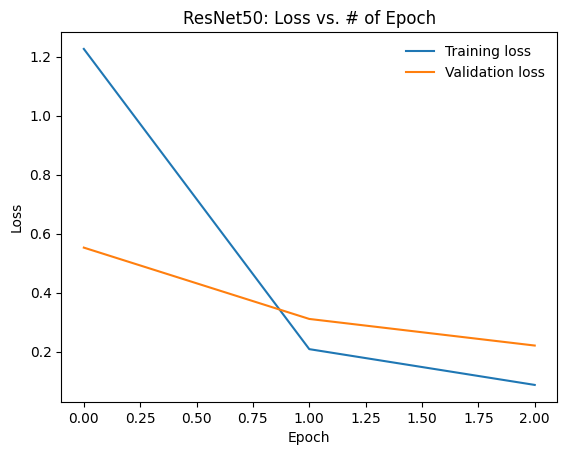

In [ ]:
# Printing the train and validation loss
plt.plot(train_losses_resnet, label='Training loss')
plt.plot(val_losses_resnet, label='Validation loss')
plt.legend(frameon=False)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('ResNet50: Loss vs. # of Epoch');
plt.show()

## 6.6- Ploting the Accuracy of training and validation through steps


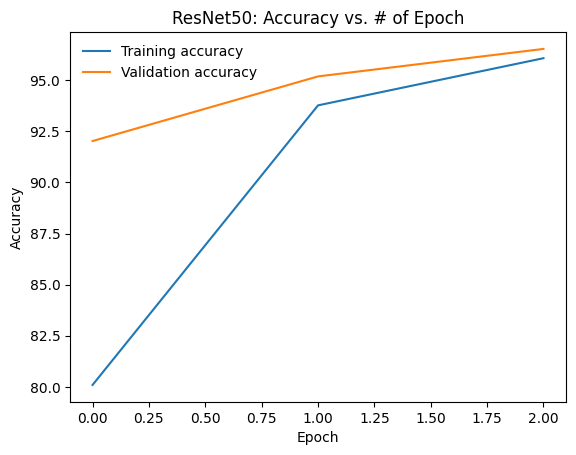

In [ ]:
# Printing the train and validation accuracy

train_accuracies_new, val_accuracies_new = [], []

# Since each element in train_accuracy is a type torch.tensor, need to convert to a float - done by iterating through entire list
for index in range(len(train_accuracies_resnet)):
  train_accuracies_new.append(train_accuracies_resnet[index].clone().detach().item())

for index in range(len(val_accuracies_resnet)):
  val_accuracies_new.append(val_accuracies_resnet[index].clone().detach().item())

plt.plot(train_accuracies_new, label='Training accuracy')
plt.plot(val_accuracies_new, label='Validation accuracy')
plt.legend(frameon=False)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('ResNet50: Accuracy vs. # of Epoch');
plt.show()

## 6.7- Assessing the models Performance

After training the model, it's time now to test the models' performance on test data set. The best model is selected to be tested agains the test data set. The model has not been exposed to test set, so it time to test the model against real data. At the end, the accuracy of the model is printed when checked against the test data set.

## 6.8- Calculating model's accuracy on test data set

The following function is used to test the model using the test dataset. It will be used for 4 models. This function will also be used to show the misclassified images as well as the confusion matrix.

In [ ]:
from sklearn.metrics import confusion_matrix

def test(model, test_dataloader):
    """
    Input: Deep Learning Model, test data
    Output: List of misclassified images, list of predicted labels, list of correct labels, confusion matrix
    """ 
    model.to(device)
    model.eval()

    misclassified_images = []
    predicted_labels = []
    correct_labels = []
    
    correct_val, total_val = 0, 0

    with torch.no_grad():
        for images, labels in test_dataloader:
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            predicted = torch.max(output, dim=1)[1]
            incorrect_indices = (predicted != labels).nonzero()

            for index in incorrect_indices:
                misclassified_images.append(images[index].cpu().numpy())
                predicted_labels.append(predicted[index].item())
                correct_labels.append(labels[index].item())

            correct_val += (torch.max(output, dim=1)[1] == labels).sum()
            total_val += labels.size(0)

    accuracy = correct_val / total_val * 100
    print(f'Test accuracy {accuracy:.3f}.', end=' ')
    
    # Create confusion matrix
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for images, labels in test_dataloader:
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            predicted = torch.max(output, dim=1)[1]
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
    cm = confusion_matrix(all_labels, all_preds)
    
    return misclassified_images, predicted_labels, correct_labels, accuracy, cm


In [ ]:
# Test the model
resnet.load_state_dict(best_state_resnet)
misclassified_images, predicted_labels, correct_labels, accuracy, cm = test(resnet,test_loader)

Test accuracy 96.650. 

## Utility function to plot the misclassified images and their labels (false and true)

The following function is used to plot the misclassified images, and it will be used for all 4 models. Note that due to the normalization and transformations done in the pre-processing, the images may appear differently than expected (ex. darker).

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_misclassified_images(images, correct_labels,wrong_labels, num_images=20):
    """
    Input: Images, list of correct labels, list of wrong labels, number of images which is default to 20
    Output: Creates a plot of misclassified images
    """ 
    fig, axes = plt.subplots(5, 4, figsize=(12, 6))
    fig.suptitle('Misclassified Images', fontsize=16)

    for i, ax in enumerate(axes.flat):
        if i < num_images:
            image = images[i]
            image = image.squeeze()  # Remove the batch dimension
            image = image.transpose(1, 2, 0) # Change the order of dimensions to (H, W, C)
            correct_label = correct_labels[i]
            wrong_label = wrong_labels[i]

            ax.imshow(np.clip(image, 0, 1))
            ax.set_title(f'Assigned: {wrong_label},True: {correct_label}')
            ax.set_xticks([])
            ax.set_yticks([])
        else:
            ax.axis('off')

    plt.tight_layout()
    plt.show()


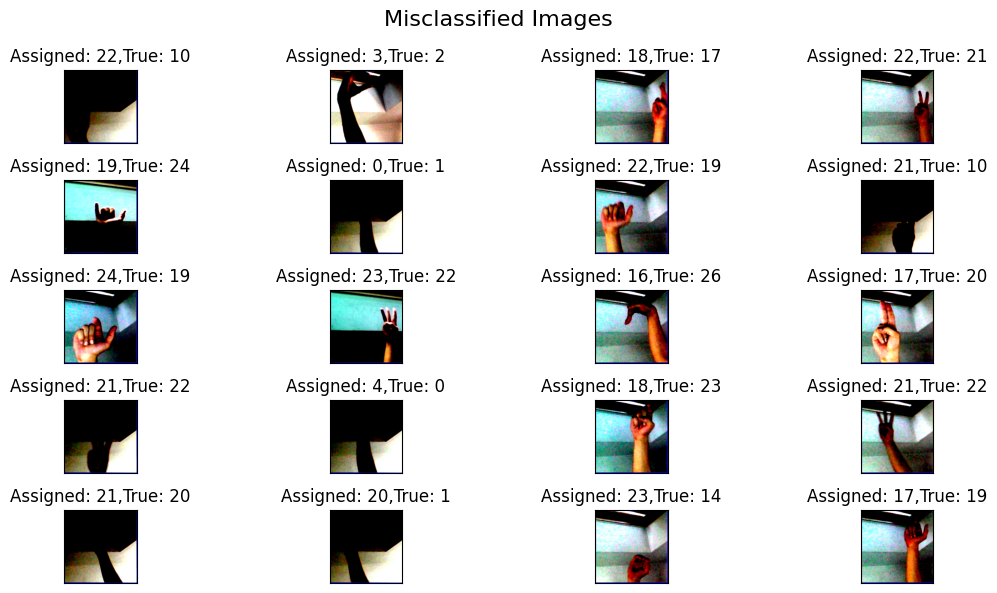

In [ ]:
plot_misclassified_images(misclassified_images, correct_labels, predicted_labels)

## Utility function to plot the confusion matrix 

The following function is used to plot the confusion matrix, and it will be used for all 4 models.

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    Input: variable cm (confusion matrix), list of classes, apply normalization or not (can set to True), title, colormap
    Output: Plots the confusion matrix
    """
    plt.rcParams['figure.figsize'] = (20, 20) # Adjust the figure size
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.rcParams['figure.figsize'] = (8, 6) # Reset to default size
    return plt.show()


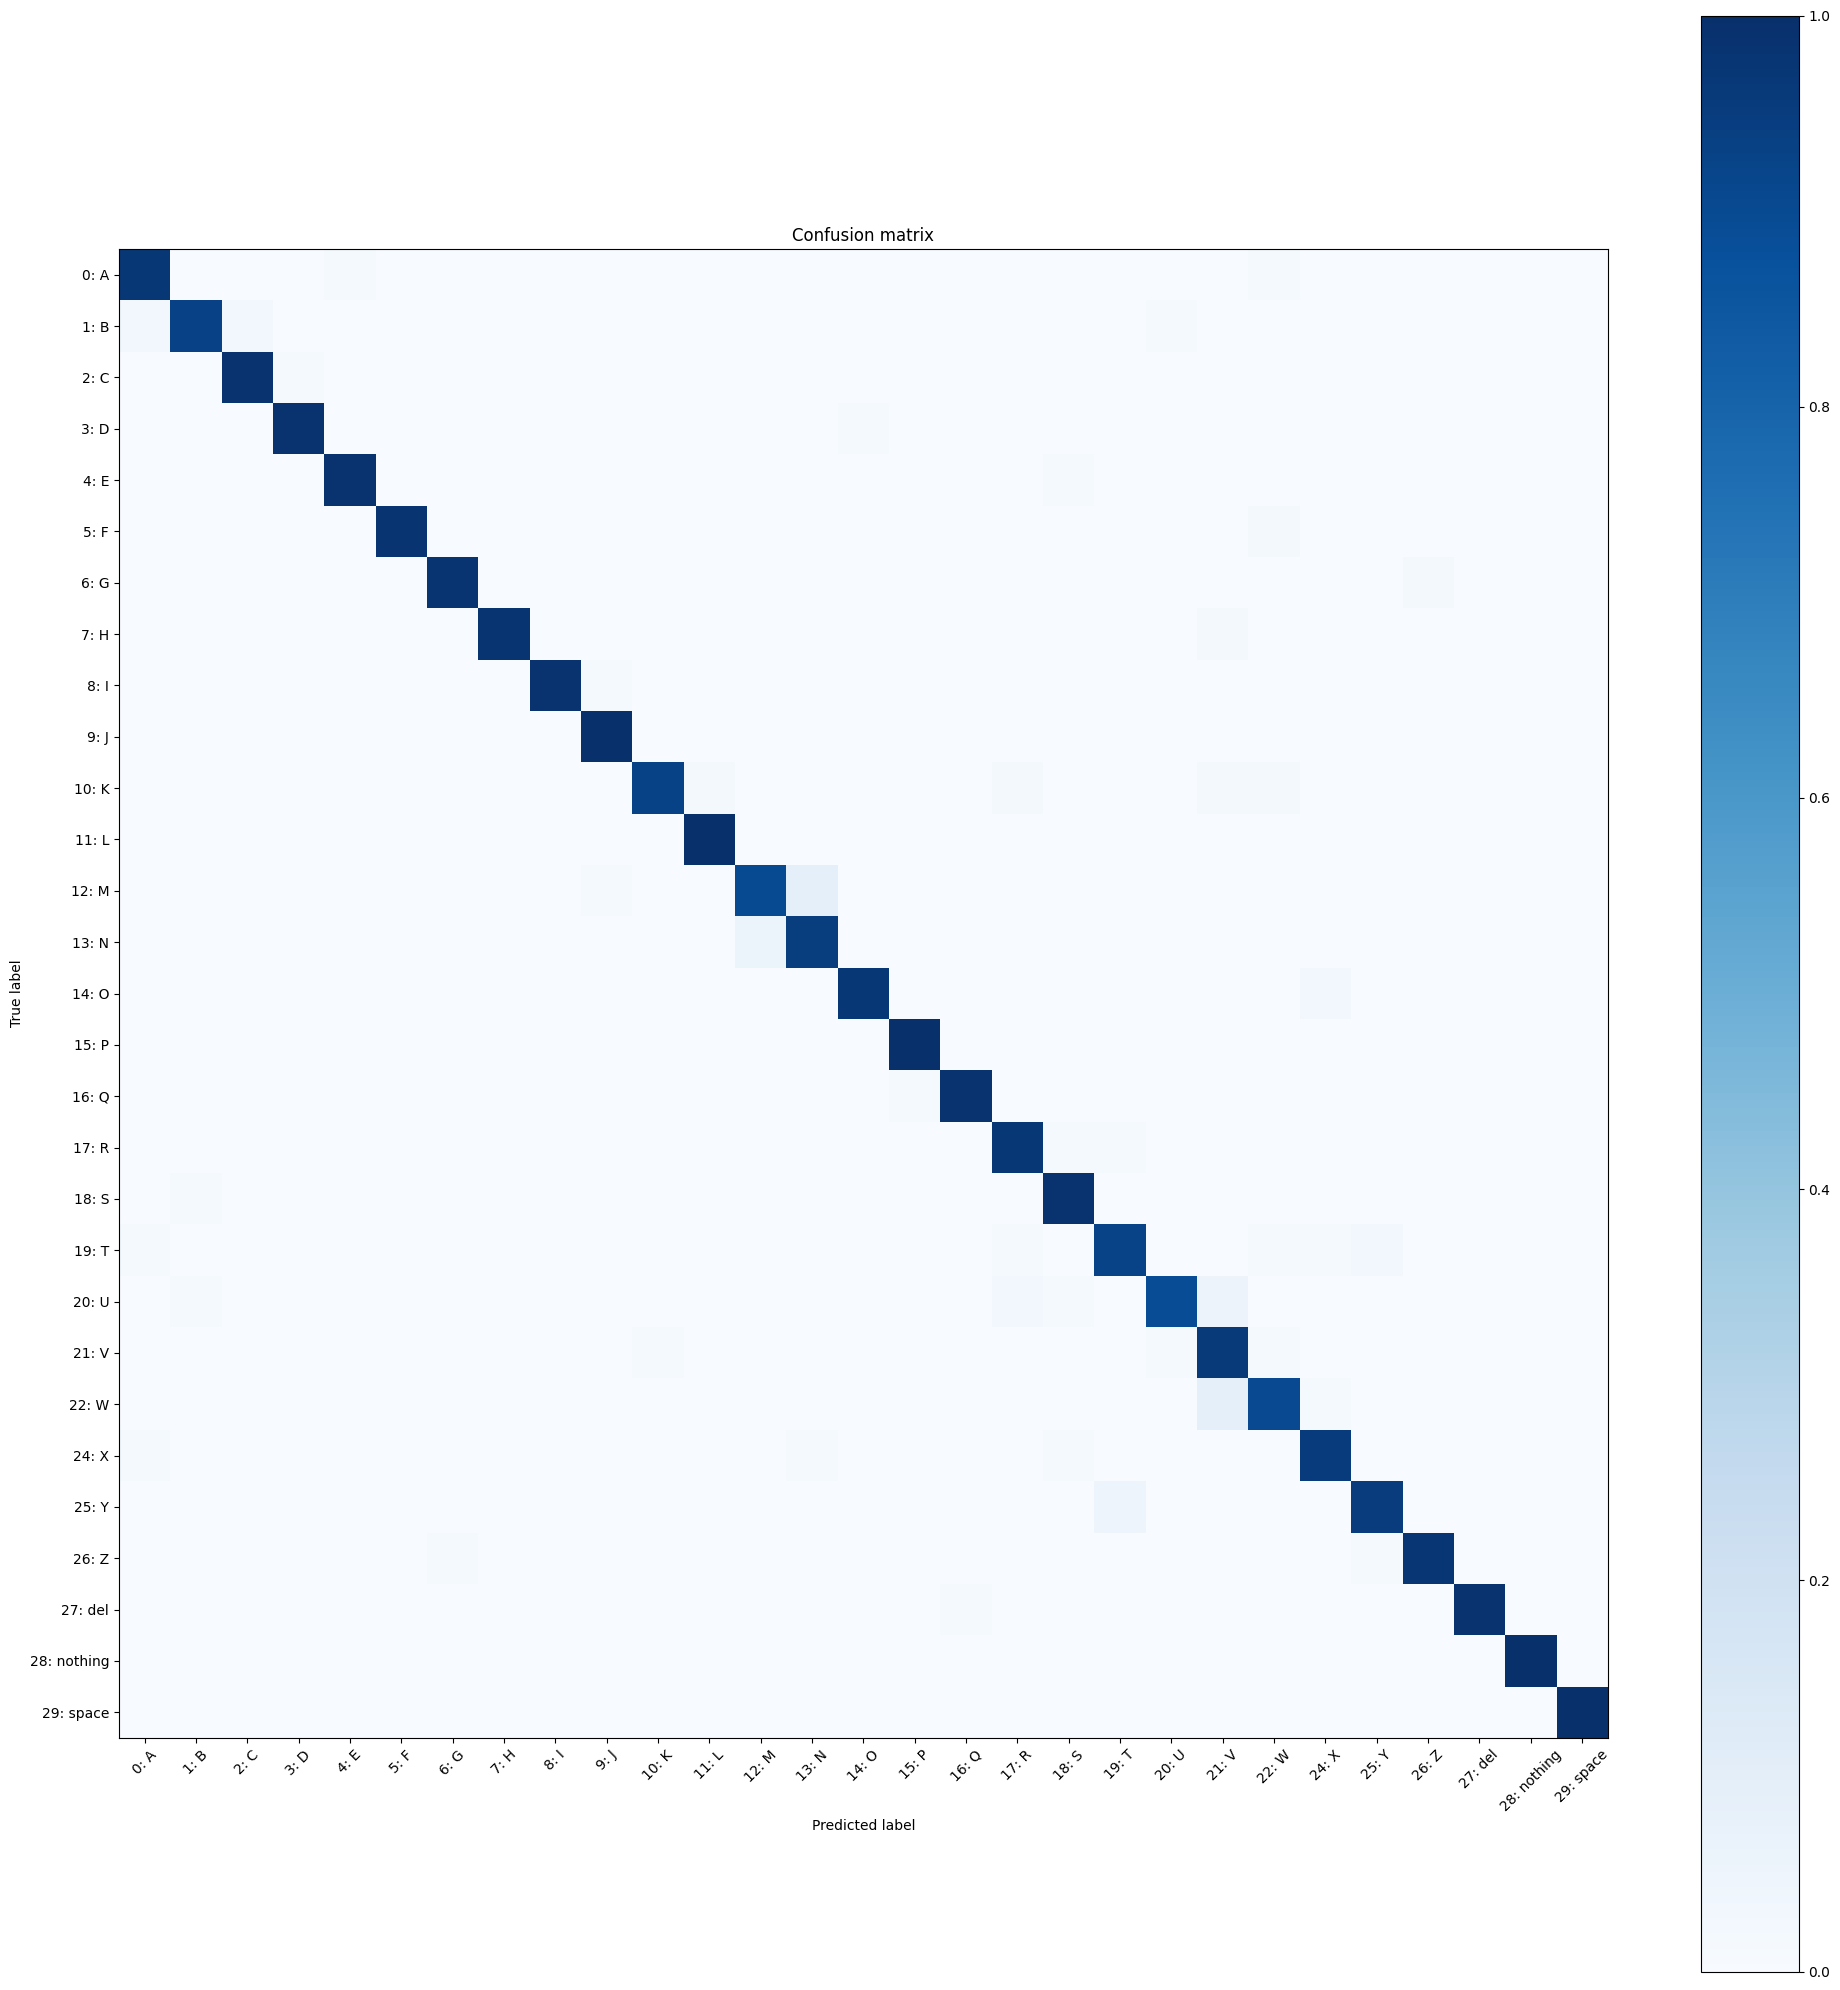

In [ ]:
plot_confusion_matrix(cm, classes, normalize = True)

## 6.9- Summary of ResNet50:

We trained this model with 3 epochs which resulted a training and validation loss of 0.087 and 0.221, respectively. The accuracy of this model for training and validation set were 96.075% and 96.529% respectively.

We then tested this model against the test set which resulted in a 96.650% accuracy.


# 7- Setting up second Convolutional Neural Network model - VGG16

The second model we explore is VGG16. It does not have any residual blocks. The details of the model are included in the report.

## 7.1- loading VGG16 from Pytorch as deep learning model

The following will also print a summary of the model's layers.

In [ ]:
#importing resnet from torch models
vgg16 = models.vgg16(weights='VGG16_Weights.DEFAULT')

# freezing the parameters (--> no training on resnet parameters)
for param in vgg16.parameters():
    param.requires_grad = False

# set output classes to the classes we have in dataset
final_layer = nn.Linear(in_features=4096, out_features=len(classes))
vgg16.classifier[-1] = final_layer

# print the model details
vgg16

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:06<00:00, 91.7MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

## 7.2- Setting up the trainable parameters, loss criterion and optimization model for training

Cross entropy is used as the criterion loss functions. For optimization, Adam's method is used for defining steps in gradient descent. 

In [ ]:
# selecting paramerters to be updated during training
params_to_update = []
for name, param in vgg16.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)

# setting up optimization and loss fucntion
vgg16_criterion = nn.CrossEntropyLoss()
vgg16_optimizer = torch.optim.Adam(params_to_update, lr=0.001)

## 7.3- Train and evaluate the model and print the results

In [ ]:
num_epoch = 3

best_state_vgg16, train_losses_vgg16, val_losses_vgg16, train_accuracies_vgg16, val_accuracies_vgg16 = train(
    model=vgg16,
    criterion=vgg16_criterion,
    optimizer=vgg16_optimizer,
    train_dataloader=train_loader,
    val_dataloader=val_loader,
    num_epoch=num_epoch
)

Saving model

Epoch 1, Batch 609, Step 609:
Train acc 73.415. Train loss 0.922 | Val loss 0.365. Val acc 91.765. Epoch took 626.6309750080109 seconds
Saving model

Epoch 2, Batch 609, Step 1218:
Train acc 81.988. Train loss 0.282 | Val loss 0.236. Val acc 94.857. Epoch took 626.0821762084961 seconds
Saving model

Epoch 3, Batch 609, Step 1827:
Train acc 83.796. Train loss 0.167 | Val loss 0.202. Val acc 95.155. Epoch took 626.4461750984192 seconds


## 7.4- Ploting the loss of training and validation through steps


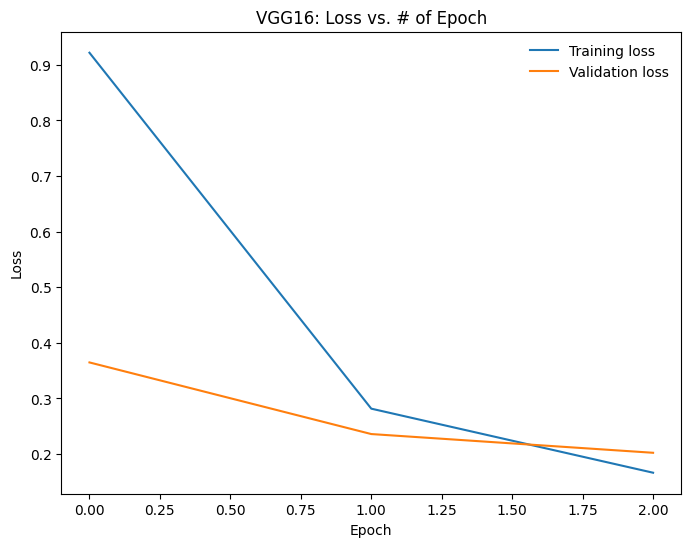

In [ ]:
# Printing the train and validation loss

plt.plot(train_losses_vgg16, label='Training loss')
plt.plot(val_losses_vgg16, label='Validation loss')
plt.legend(frameon=False)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('VGG16: Loss vs. # of Epoch');
plt.show()

## 7.5- Ploting the Accuracy of training and validation through steps


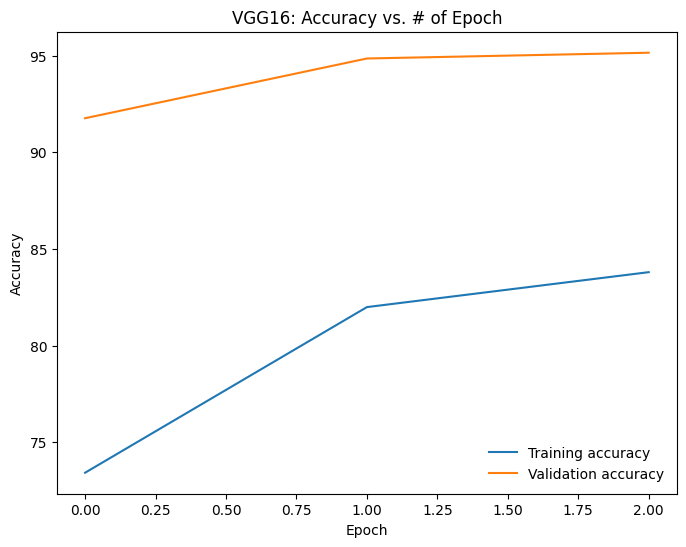

In [ ]:
# Printing the train and validation accuracy

train_accuracies_new, val_accuracies_new = [], []

# Since each element in train_accuracy is a type torch.tensor, need to convert to a float - done by iterating through entire list
for index in range(len(train_accuracies_vgg16)):
  train_accuracies_new.append(train_accuracies_vgg16[index].clone().detach().item())

for index in range(len(val_accuracies_vgg16)):
  val_accuracies_new.append(val_accuracies_vgg16[index].clone().detach().item())

plt.plot(train_accuracies_new, label='Training accuracy')
plt.plot(val_accuracies_new, label='Validation accuracy')
plt.legend(frameon=False)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('VGG16: Accuracy vs. # of Epoch');
plt.show()

## 7.6- Calculating model's accuracy on test data set

In [ ]:
# Put the model to test
vgg16.load_state_dict(best_state_vgg16)
misclassified_images, predicted_labels, correct_labels, accuracy, cm = test(vgg16,test_loader)

Test accuracy 95.550. 

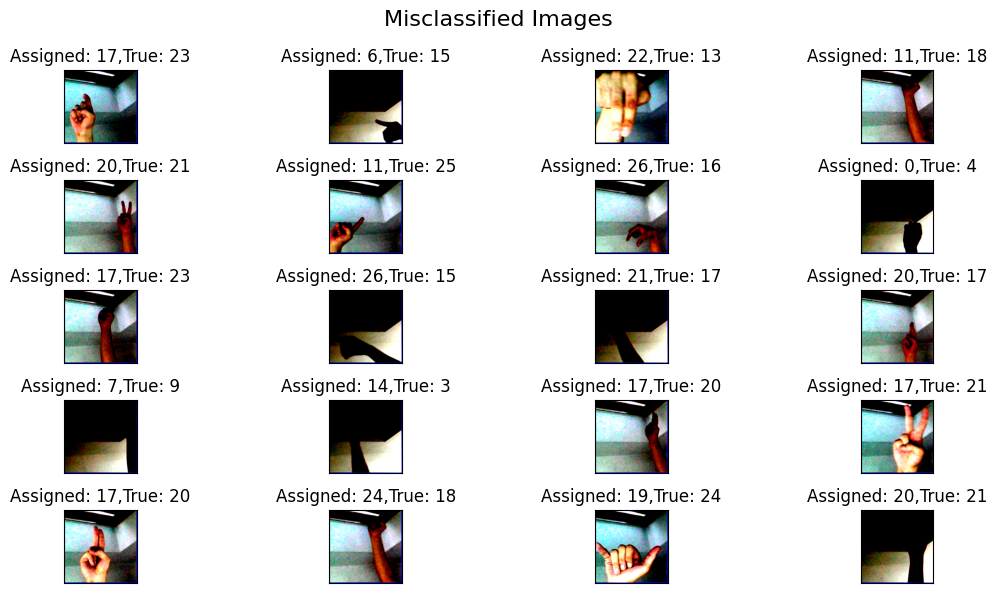

In [ ]:
plot_misclassified_images(misclassified_images, correct_labels, predicted_labels)

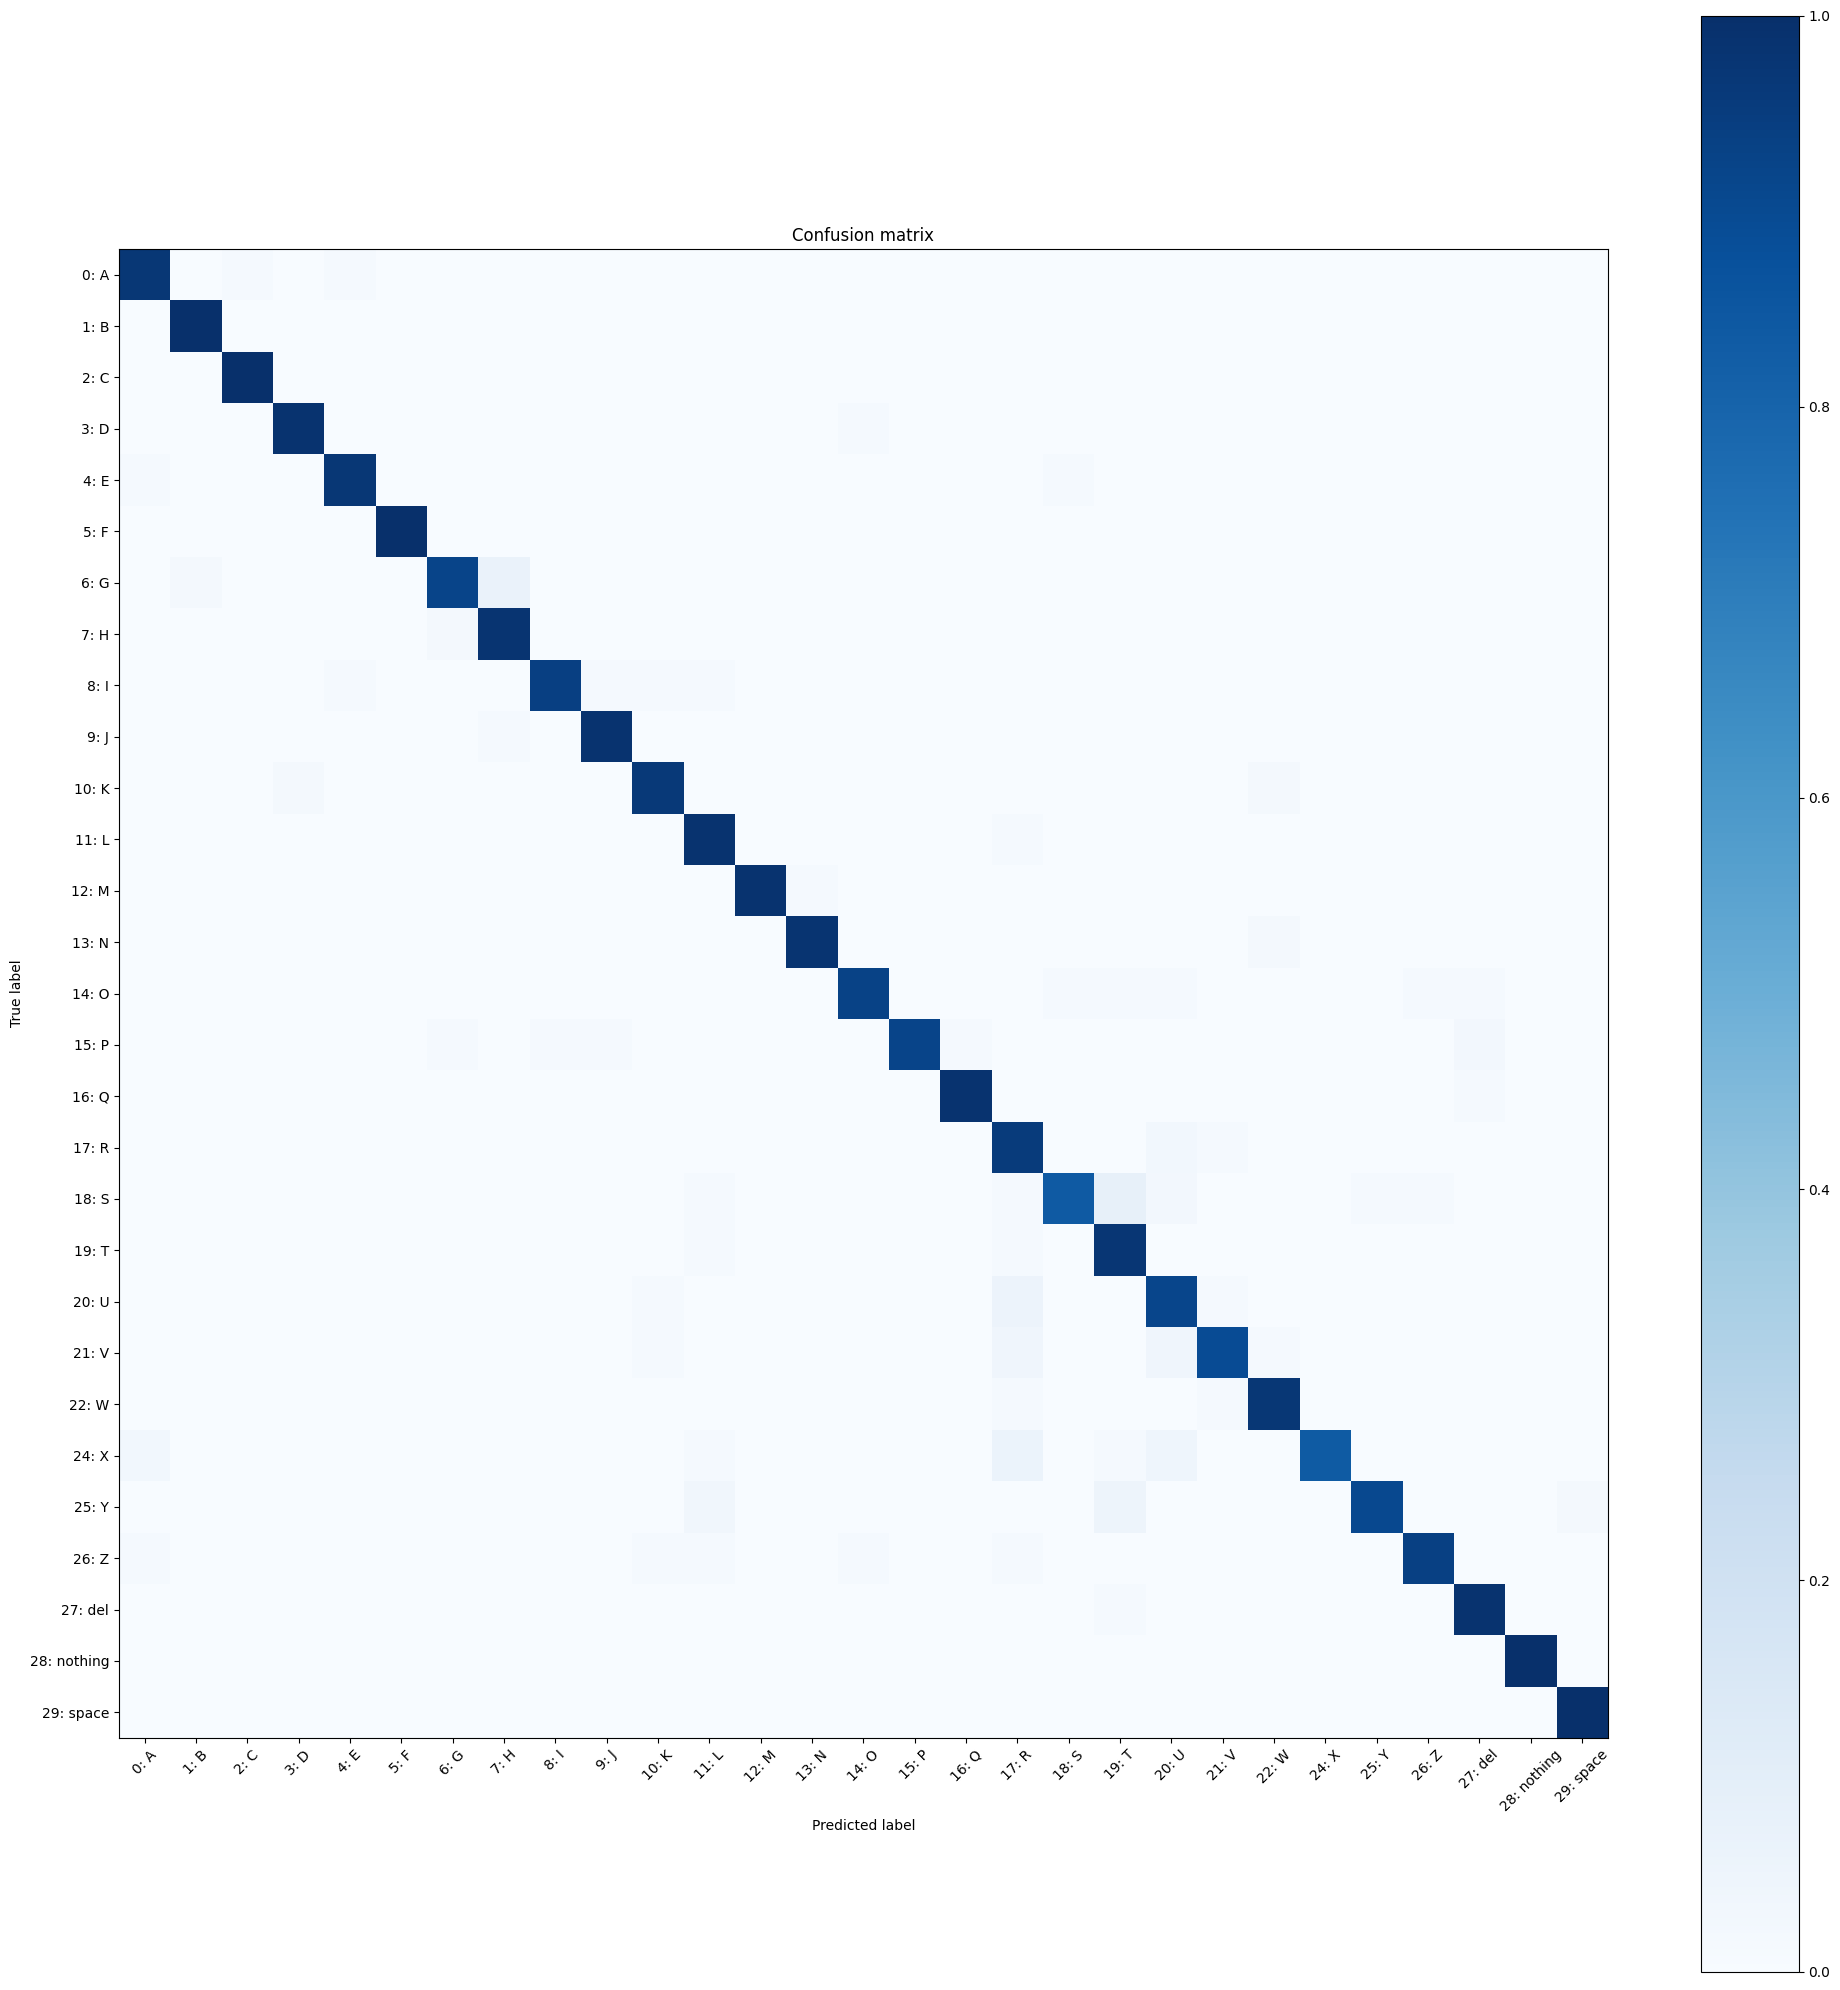

In [ ]:
plot_confusion_matrix(cm, classes, normalize = True)

## 7.7- Assessing the models Performance

Similar to the ResNet model, we evaluated the model's performance using test data set which resulted in a 95.550% accuracy.

# 8- Setting up the third Convolutional Neural Network model - GoogleNet

The third model we explore is GoogleNet. The details of the model are included in the report.

## 8.1- loading GoogleNet from Pytorch as deep learning model

The following will also print a summary of the model's layers.

In [ ]:
googlenet = models.googlenet(weights='GoogLeNet_Weights.DEFAULT')

for param in googlenet.parameters():
    param.requires_grad = False

# set output classes to the classes we have in dataset
in_features = googlenet.fc.in_features
fc = nn.Linear(in_features=in_features, out_features=len(classes))
googlenet.fc = fc

# print the model details
googlenet

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:01<00:00, 47.9MB/s]


GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

## 8.2- Setting up the trainable parameters, loss criterion and optimization model for training

Cross entropy is used as the criterion loss functions. For optimization, Adam's method is used for defining steps in gradient descent. 

In [ ]:
# selecting paramerters to be updated during training
params_to_update = []
for name, param in googlenet.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)

# setting up optimization and loss fucntion
googlenet_criterion = nn.CrossEntropyLoss()
googlenet_optimizer = torch.optim.Adam(params_to_update, lr=0.001)

## 8.3- Train and evaluate the model and print the results

In [ ]:
num_epoch = 3

best_state_googlenet, train_losses_googlenet, val_losses_googlenet, train_accuracies_googlenet, val_accuracies_googlenet = train(
    model=googlenet,
    criterion=googlenet_criterion,
    optimizer=googlenet_optimizer,
    train_dataloader=train_loader,
    val_dataloader=val_loader,
    num_epoch=num_epoch
)

Saving model

Epoch 1, Batch 609, Step 609:
Train acc 76.011. Train loss 1.234 | Val loss 0.542. Val acc 90.840. Epoch took 320.05568385124207 seconds
Saving model

Epoch 2, Batch 609, Step 1218:
Train acc 89.116. Train loss 0.249 | Val loss 0.334. Val acc 93.615. Epoch took 319.7474308013916 seconds
Saving model

Epoch 3, Batch 609, Step 1827:
Train acc 91.284. Train loss 0.122 | Val loss 0.251. Val acc 94.897. Epoch took 319.6486737728119 seconds


##8.4- Ploting the loss of training and validation through steps


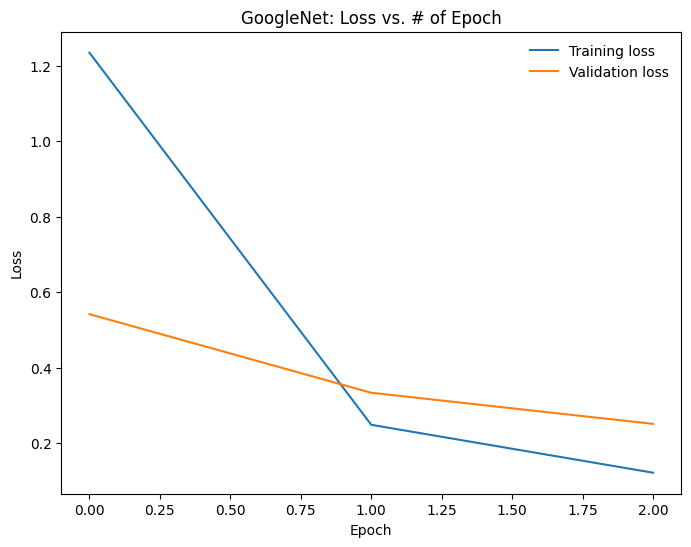

In [ ]:
# Printing the train and validation loss

plt.plot(train_losses_googlenet, label='Training loss')
plt.plot(val_losses_googlenet, label='Validation loss')
plt.legend(frameon=False)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('GoogleNet: Loss vs. # of Epoch');
plt.show()

## 8.5- Ploting the Accuracy of training and validation through steps


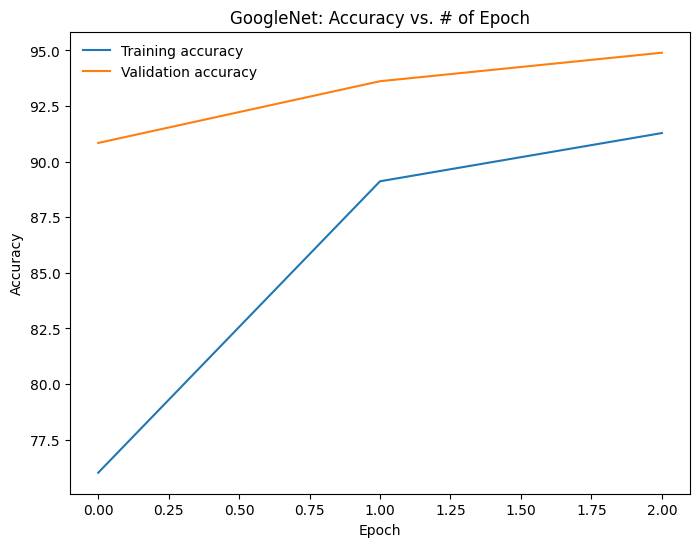

In [ ]:
# Printing the train and validation accuracy

train_accuracies_new, val_accuracies_new = [], []

# Since each element in train_accuracy is a type torch.tensor, need to convert to a float - done by iterating through entire list
for index in range(len(train_accuracies_googlenet)):
  train_accuracies_new.append(train_accuracies_googlenet[index].clone().detach().item())

for index in range(len(val_accuracies_googlenet)):
  val_accuracies_new.append(val_accuracies_googlenet[index].clone().detach().item())

plt.plot(train_accuracies_new, label='Training accuracy')
plt.plot(val_accuracies_new, label='Validation accuracy')
plt.legend(frameon=False)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('GoogleNet: Accuracy vs. # of Epoch');
plt.show()

## 8.6- Calculating model's accuracy on test data set

In [ ]:
# Put the model to test
googlenet.load_state_dict(best_state_googlenet)
misclassified_images, predicted_labels, correct_labels, accuracy, cm = test(googlenet, test_loader)

Test accuracy 94.600. 

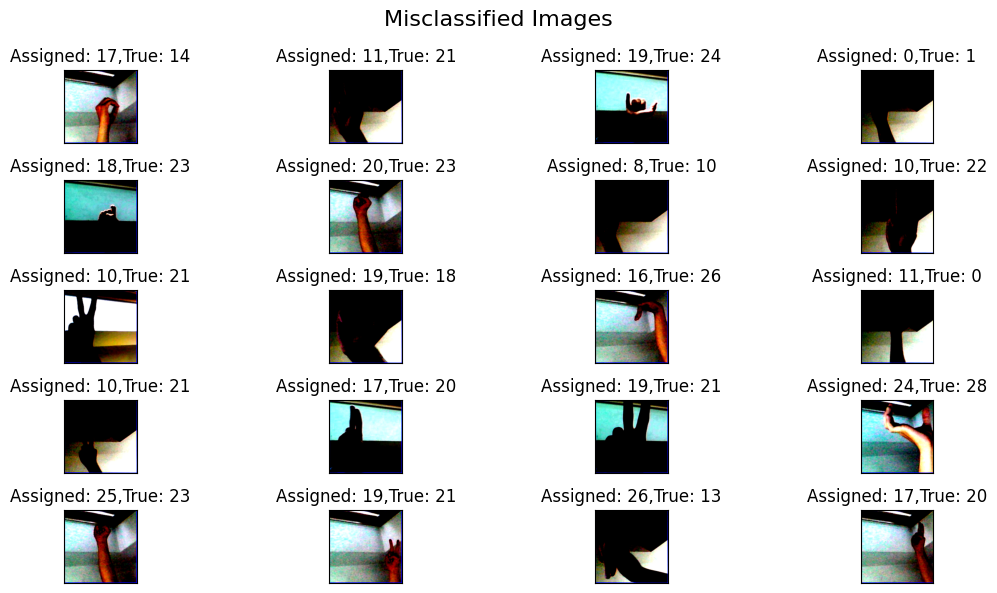

In [ ]:
plot_misclassified_images(misclassified_images, correct_labels, predicted_labels)

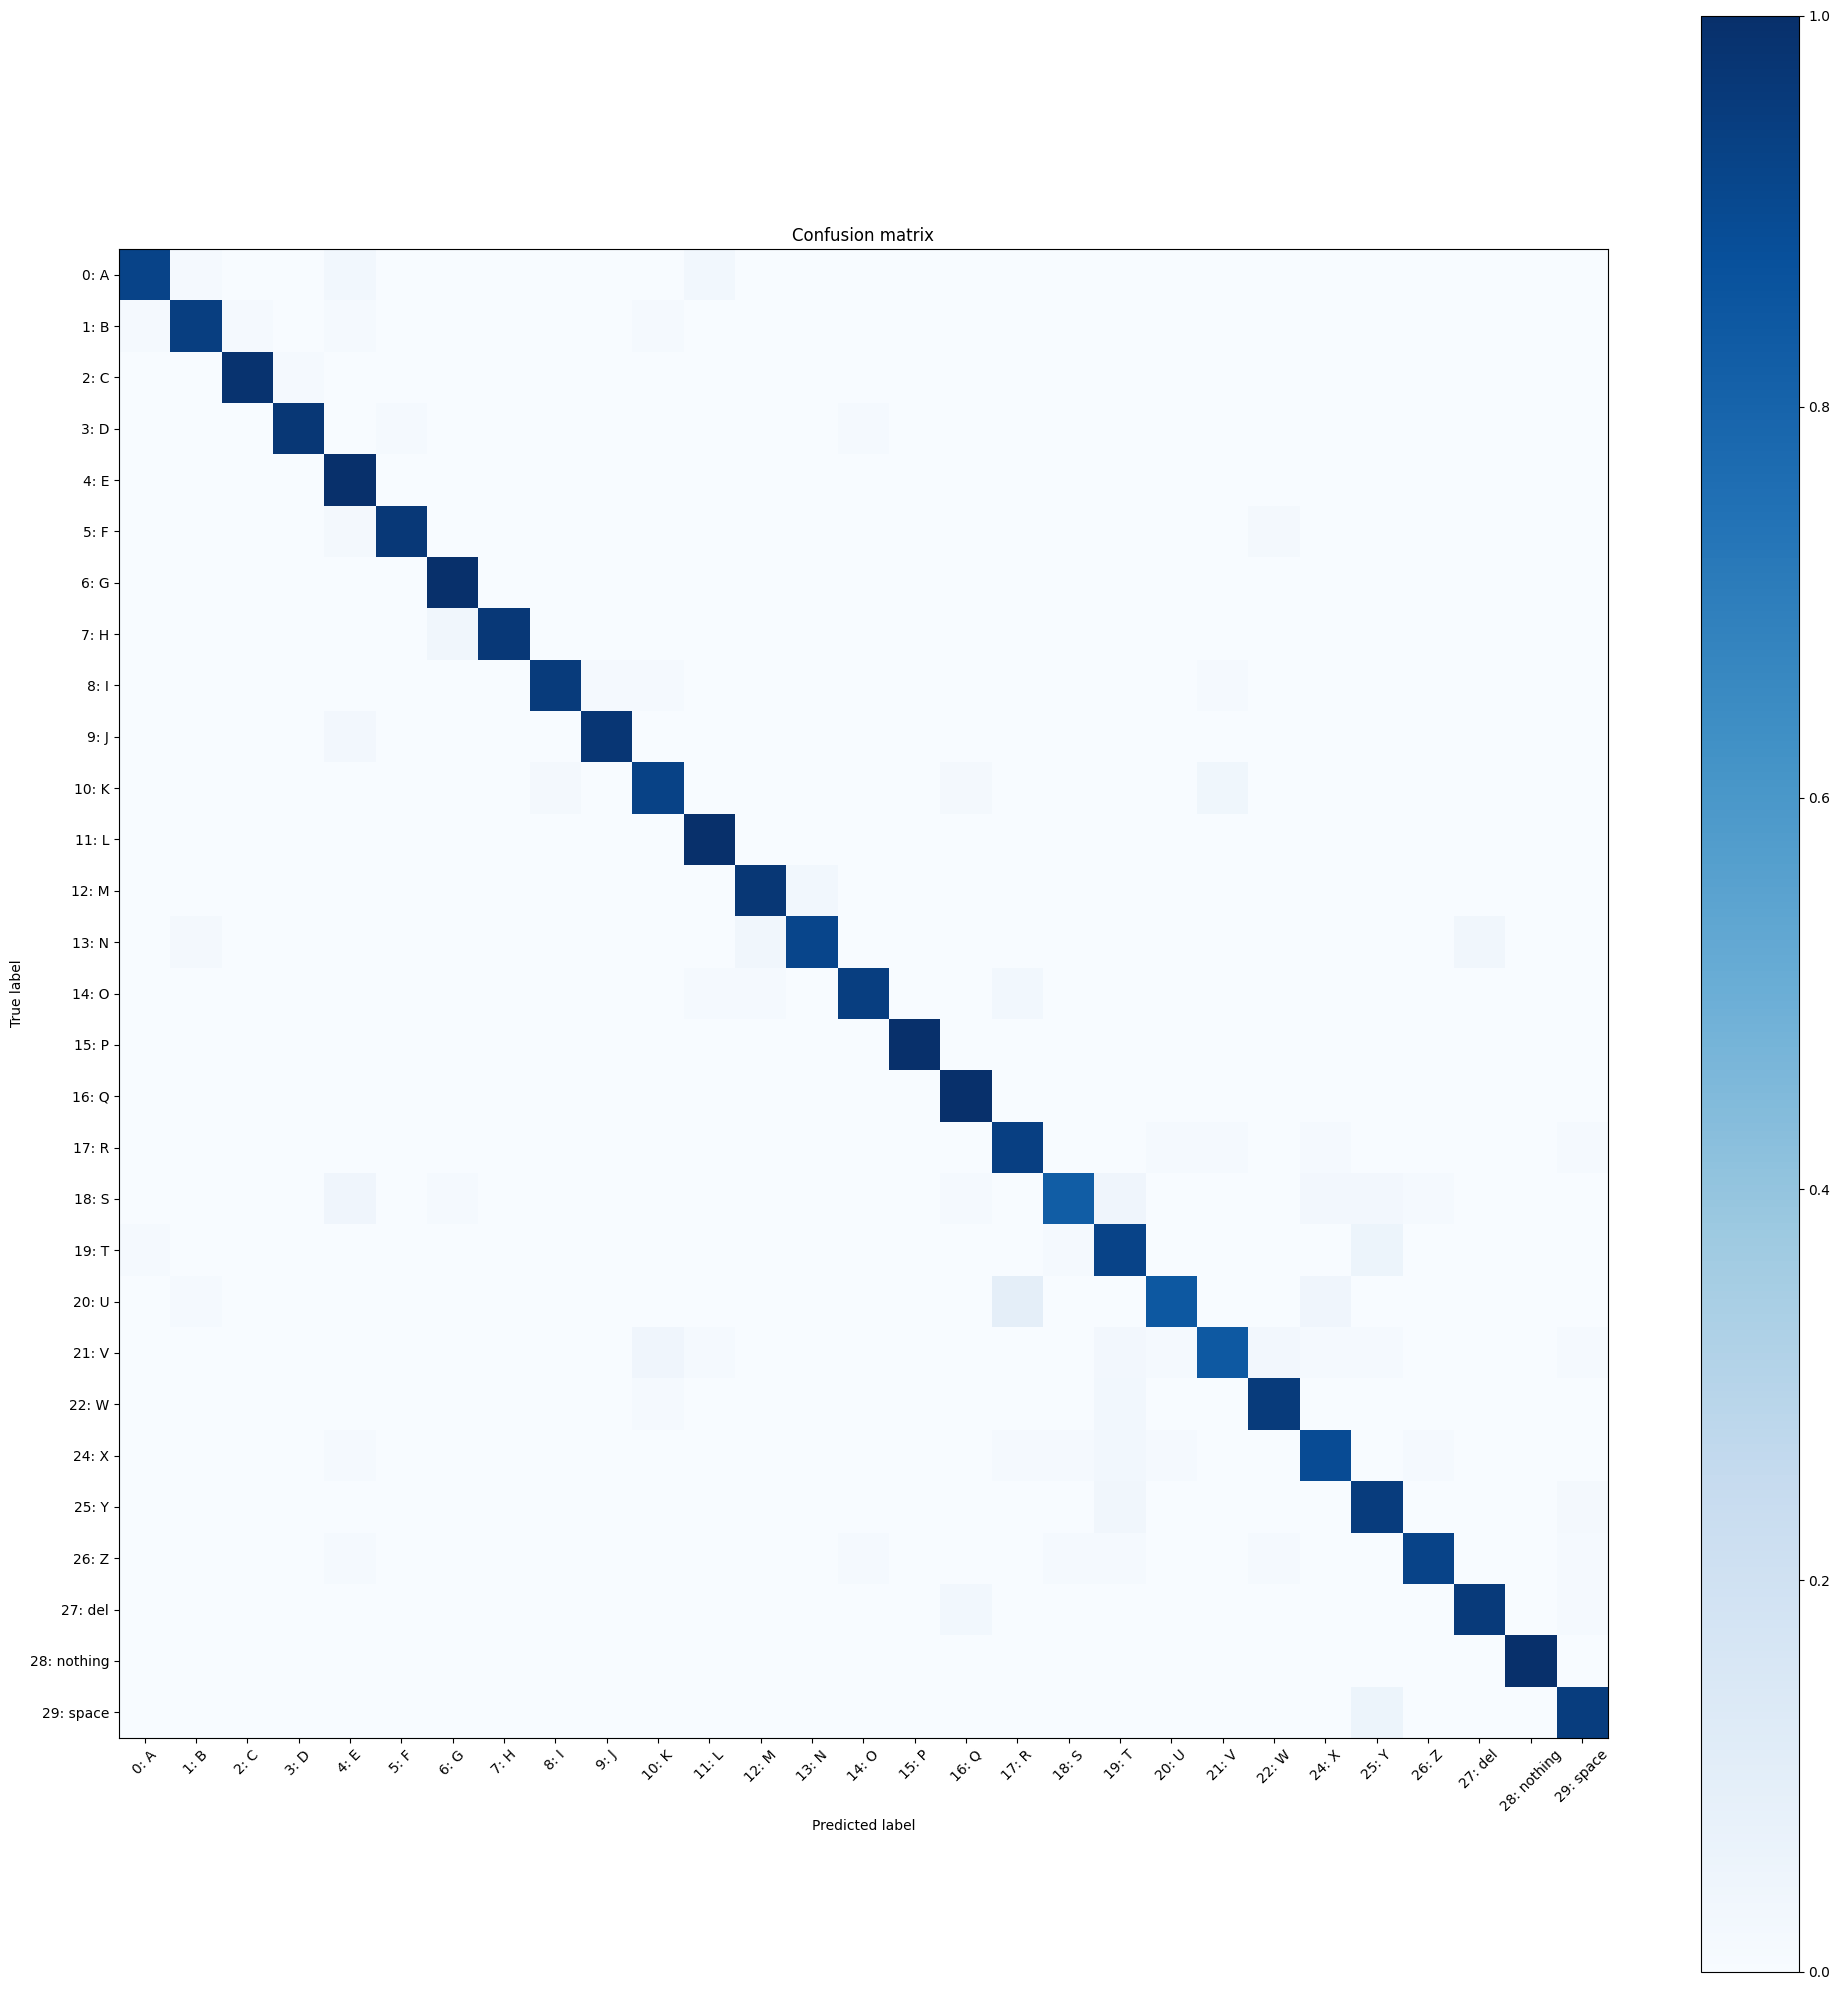

In [ ]:
plot_confusion_matrix(cm, classes, normalize = True)

## 8.7- Assessing the models Performance

Same as two previous models, we test evaluate the model's performance using test data set which resulted in a 94.6% accuracy.

# 9.	Setting up our own Convolutional Neural Network

The previous 3 models have been pre-trained models. We wanted to create a custom untrained deep learning model and compare the results to the pre-trained models. This CNN model was inspired by the model we used in our previous assignment, but has been modified for the purposes of classifying the ASL alphabet. After the creation of this model, we can use the same steps previously for training, testing, and displaying the misclassified images & confusion matrix.

## 9.1- Creating the custom CNN using Pytorch

First, the nn.Module class, which is the super class for all neural networks in PyTorch, will be inherited. Then, we will add the following layers to the convolutional neural network:

- Sequential Layer 1: 
    - convolutional layer with kernel size of 3 * 3, padding = 1 (zero_padding), stride = 1
    - batch normalization layer
    - ReLU activation function
    - max pooling layer with kernel size of 2 * 2, stride = 2

- Sequential Layer 2:
    - convolutional layer with kernel size of 3 * 3, padding = 0, stride = 1
    - batch normalization layer
    - ReLU activation function
    - max pooling layer with kernel size of 2 * 2, stride = 2


- Fully Connected Layer 1:
    - Linear transformation where the input feature size is the dimensions of each piece of data from the previous layers (55 * 55 * 64), and the output is 600.
- Dropout layer with 0.25 class probability


- Fully Connected Layer 2:
    - Linear transformation where the input feature size is the previous layer output (600), and the output size is 120.

- Fully Connected Layer 3:
    - Linear transformation where the input feature size is the previous layer output (120), and the output size is the number of labels (29).

Our input image goes through the each layer and is manipulated as follows:
- first convolutional layer : input: 224 * 224 * 3, output: 224 * 224 * 32
- first max pooling layer : input: 224 * 224 * 32, output: 112 * 112 * 32
- second convolutional layer : input : 112 * 112 * 32, output: 110 * 110 * 64
- second max pooling layer : 110 * 110 * 64, output: 55 * 55 * 64
- fully connected layer : input 64 * 55 * 55, output: 600
  - dropout (0.25)
- fully connected layer : input 600, output: 120
- fully connected layer : input 120, output: 29

In [ ]:
class CustomCNN(nn.Module):
    
    def __init__(self):
        super(CustomCNN, self).__init__()
        
        # Sequential Layer 1
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Sequential Layer 2
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        #Fully Connected Layers
        self.fc1 = nn.Linear(in_features=193600, out_features=600)
        self.drop = nn.Dropout(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=len(classes))
        
    def forward(self, x):
        custom_cnn = self.layer1(x)
        custom_cnn = self.layer2(custom_cnn)
        custom_cnn = custom_cnn.view(custom_cnn.size(0), -1)
        custom_cnn = self.fc1(custom_cnn)
        custom_cnn = self.drop(custom_cnn)
        custom_cnn = self.fc2(custom_cnn)
        custom_cnn = self.fc3(custom_cnn)
        
        return custom_cnn

## 9.2 Initializing the Custom CNN and Optimization/Loss

In [ ]:
custom_cnn = CustomCNN()
custom_cnn.to(device)

# setting up optimization and loss fucntion
custom_criterion = nn.CrossEntropyLoss()
custom_optimizer = torch.optim.Adam(custom_cnn.parameters(), lr=0.001)

print(custom_cnn)

CustomCNN(
  (layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=193600, out_features=600, bias=True)
  (drop): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=29, bias=True)
)


## 9.3- Train and evaluate the model and print the results

In [ ]:
num_epoch = 3

best_state_customnet, train_losses_customnet, val_losses_customnet, train_accuracies_customnet, val_accuracies_customnet = train(
    model=custom_cnn,
    criterion=custom_criterion,
    optimizer=custom_optimizer,
    train_dataloader=train_loader,
    val_dataloader=val_loader,
    num_epoch=num_epoch
)

Saving model

Epoch 1, Batch 609, Step 609:
Train acc 54.448. Train loss 7.952 | Val loss 0.569. Val acc 82.535. Epoch took 392.61250853538513 seconds
Saving model

Epoch 2, Batch 609, Step 1218:
Train acc 84.704. Train loss 0.250 | Val loss 0.407. Val acc 87.863. Epoch took 379.3327603340149 seconds
Saving model

Epoch 3, Batch 609, Step 1827:
Train acc 90.011. Train loss 0.108 | Val loss 0.290. Val acc 91.529. Epoch took 378.22538328170776 seconds


## 9.4- Ploting the loss of training and validation through steps


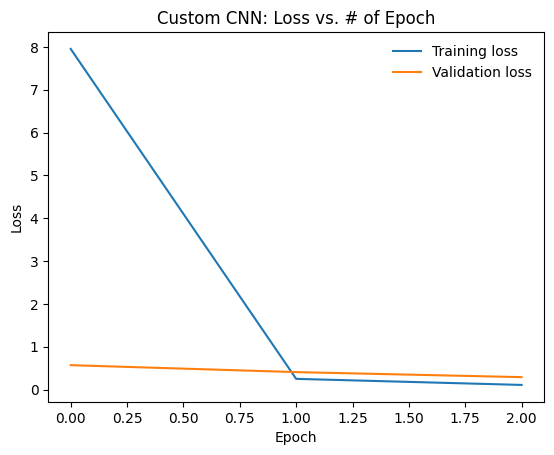

In [ ]:
# Printing the train and validation loss

plt.plot(train_losses_customnet, label='Training loss')
plt.plot(val_losses_customnet, label='Validation loss')
plt.legend(frameon=False)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Custom CNN: Loss vs. # of Epoch');
plt.show()

## 9.5- Plotting the Accuracy of training and validation through steps

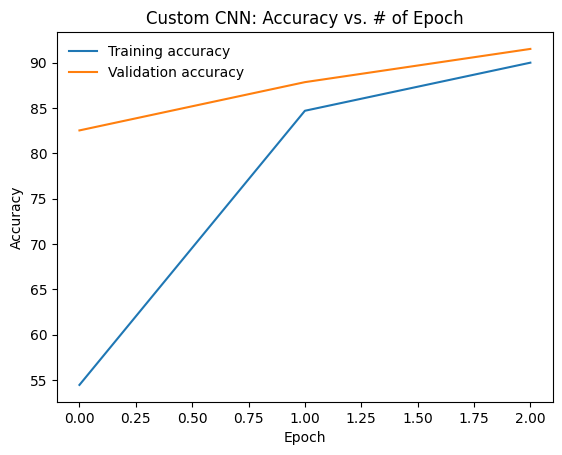

In [ ]:
# Printing the train and validation accuracy

train_accuracies_new, val_accuracies_new = [], []

# Since each element in train_accuracy is a type torch.tensor, need to convert to a float - done by iterating through entire list
for index in range(len(train_accuracies_customnet)):
  train_accuracies_new.append(train_accuracies_customnet[index].clone().detach().item())

for index in range(len(val_accuracies_customnet)):
  val_accuracies_new.append(val_accuracies_customnet[index].clone().detach().item())

plt.plot(train_accuracies_new, label='Training accuracy')
plt.plot(val_accuracies_new, label='Validation accuracy')
plt.legend(frameon=False)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Custom CNN: Accuracy vs. # of Epoch');
plt.show()

## 9.6- Calculating model's accuracy on test data set

In [ ]:
# Put the model to test
custom_cnn.load_state_dict(best_state_customnet)
misclassified_images, predicted_labels, correct_labels, accuracy, cm = test(
    model=custom_cnn,
    test_dataloader=test_loader,
)

Test accuracy 90.800. 

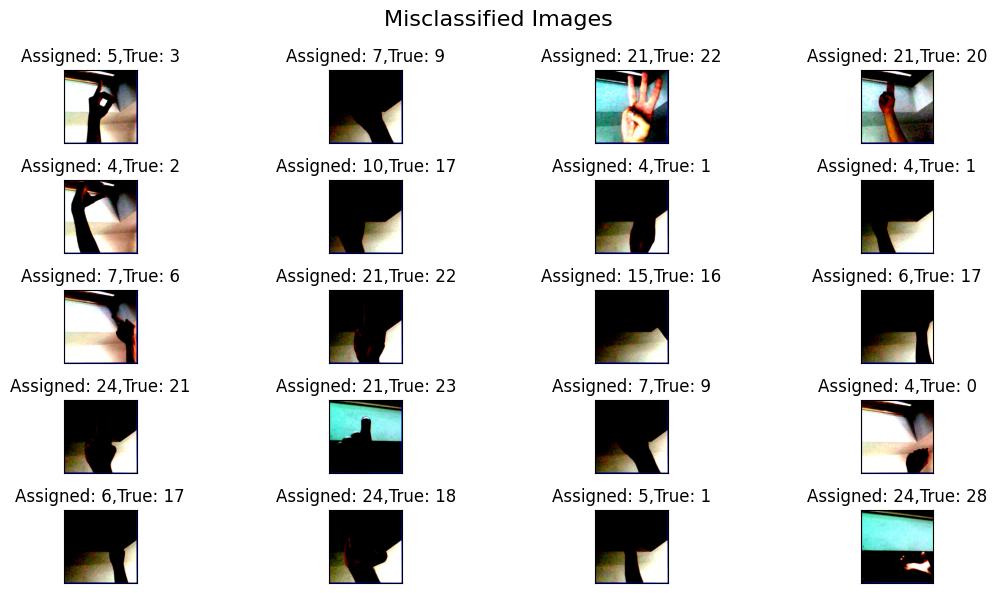

In [ ]:
plot_misclassified_images(misclassified_images, correct_labels, predicted_labels)

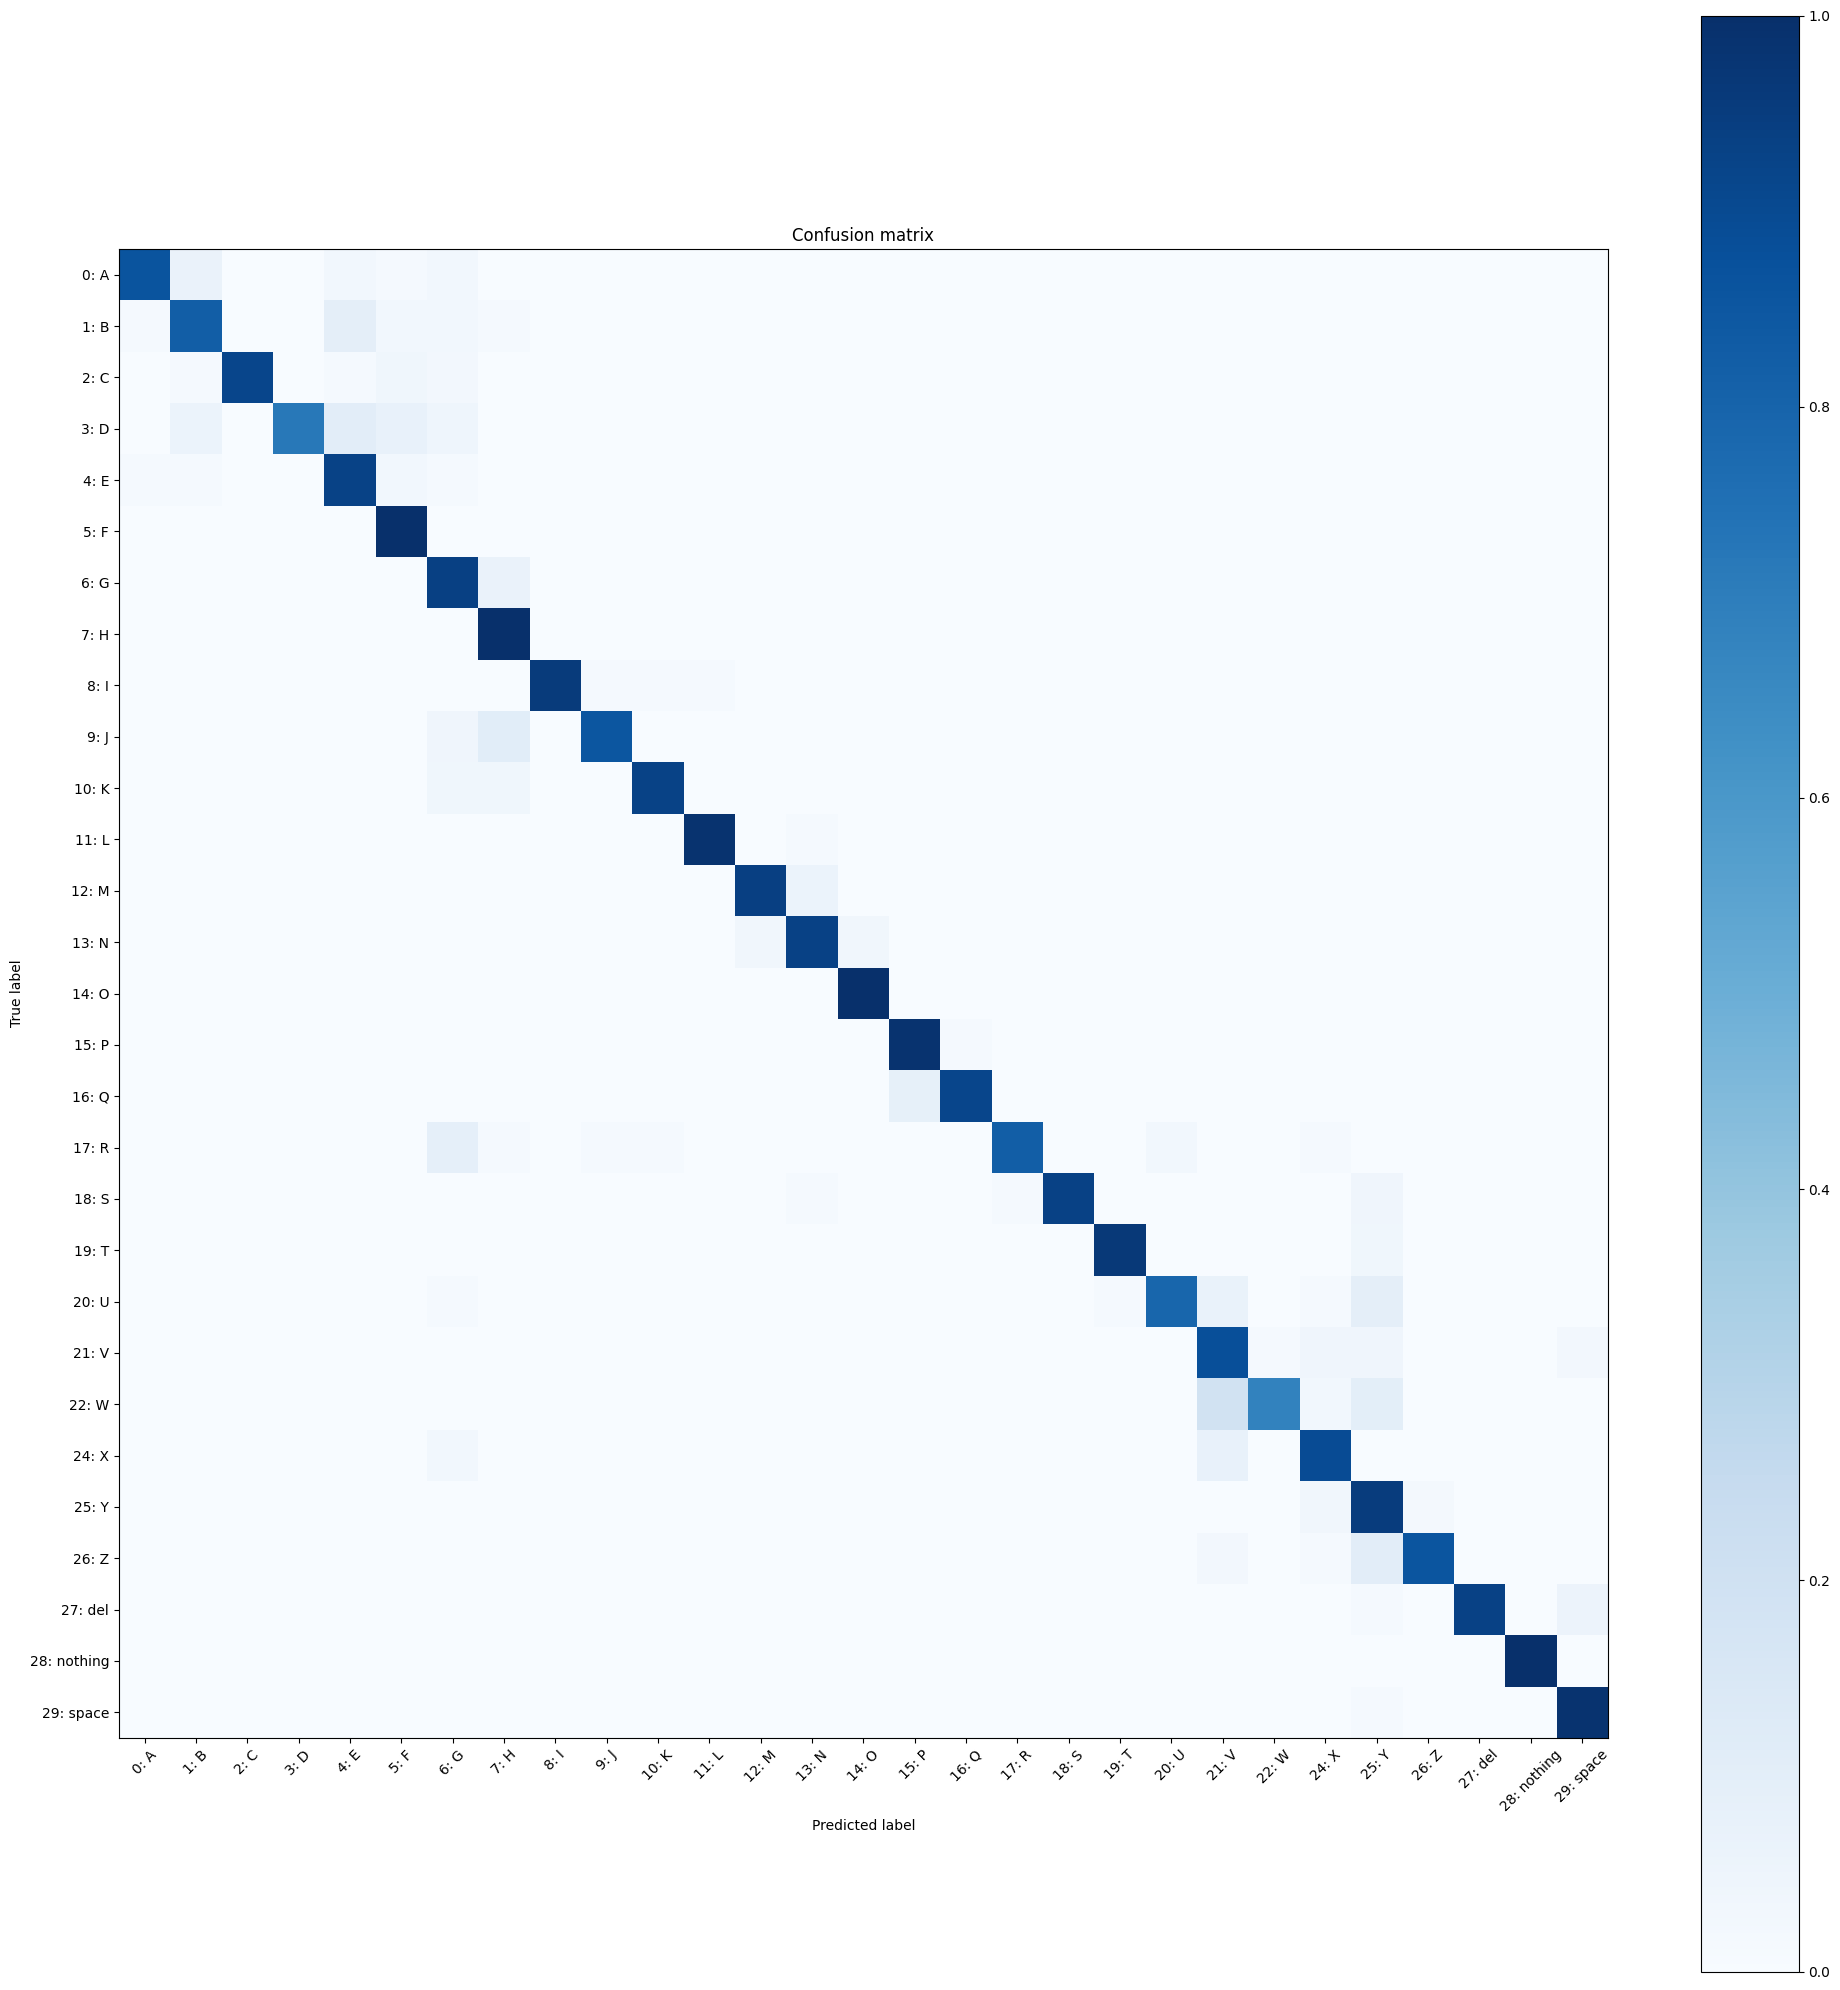

In [ ]:
plot_confusion_matrix(cm, classes, normalize = True)

## 9.7- Assessing the models Performance

Same as three previous models, we test evaluate the model's performance using test data set which resulted in a 90.8% accuracy.

#10- Conclusion

To conclude, we have investigated the classification of the American Sign Language dataset using three pre-trained models and one untrained model, for a total of four deep learning models. The table below shows a summary of their test accuracy along with how long it took to train the model using 3 epochs. Ultimately, we can say that the ResNet50 model was the most accurate for our dataset. We also can compare our untrained custom CNN model to the pre-trained models. The custom CNN was the least accurate, but it still had an adequate testing accuracy score.

| Model       | Test Accuracy |   Time (s)  |
|-------------|---------------|-------------|
| ResNet50    | 96.1%         | 1409        |
| VGG16       | 95.2%         | 1879        |
| GoogleNet   | 94.5%         | 959         |
| Custom      | 90.8%         | 1150        |